In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.providers.aer import AerSimulator

from qiskit.quantum_info import Statevector
from math import sqrt

# import basic plot tools
from qiskit.visualization import plot_histogram

# Herramientas del Qiskit textbook
from qiskit_textbook.tools import random_state, array_to_latex

# Simuladores
sim = AerSimulator()
sim_u = AerSimulator(method='unitary')

# Algoritmos cuánticos "clásicos"

Algoritmos que presentan una ventaja real sobre sus homólogos cuánticos

 - Introducidos en los años 90 del siglo XX
 - Suponen que tenemos computadores cuánticos ideales
 - Algunos de ellos carecen de utilidad práctica, mientras que otros suelen formar parte de algoritmos más complejos.

### Contenidos

1. [Paralelismo cuántico](#paralelismo)
1. [Oráculos cuánticos](#oraculo)
2. [Algoritmo de Deutsch](#deutsch)
3. [Algoritmo de Deutsch-Jozsa](#dj)
4. [Algoritmo de Bernstein-Vazirani](#bv)
4. [Algoritmo de periodicidad de Simon](#simon)
5. [Algoritmo de búsqueda de Grover: amplificación de amplitud](#grover)

# Paralelismo cuántico <a id="paralelismo"></a>

Permite evaluar una función $f(x)$ para múltiples valores de $x$ simultáneamente.

Sea $f(x): \{0,1\}\rightarrow\{0,1\}$. Para poder usar esa función en un sistema cuántico tenemos que obtener una unitaria $U_f$ que la implemente. Una forma simple es:

<img src="images/Ufsimple.svg" alt="Uf" style="width: 300px;"/>

Es fácil ver que $U_f$ es su propia inversa:

<img src="images/Ufrever.svg" alt="Uf" style="width: 700px;"/>


Para un sistema de dos cúbits $|yx\rangle=|y\rangle\otimes|x\rangle$ (siguiendo el orden de Qiskit) tenemos:

$$
U_f|yx\rangle = |y\oplus f(x)\rangle\otimes|x\rangle
$$

Si hacemos $|x\rangle = \tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ e $|y\rangle=|0\rangle$:

$$
\begin{aligned}
U_f\left(|0\rangle\otimes|\tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)\rangle\right) & 
= U_f\left(|\tfrac{1}{\sqrt{2}}(|00\rangle+|01\rangle)\right) 
= \tfrac{1}{\sqrt{2}}\left(U_f|00\rangle+U_f|01\rangle\right) \\
& = \tfrac{1}{\sqrt{2}}\left(|0\oplus f(0)\rangle\otimes|0\rangle+|0\oplus f(1)\rangle\otimes|1\rangle\right) 
= \tfrac{1}{\sqrt{2}}\left(|f(0)\rangle\otimes|0\rangle+|f(1)\rangle\otimes|1\rangle\right)
\end{aligned}
$$

Una única aplicación de $U_f$ obtiene a la vez $f(0)$ y $f(1)$.

Este resultado se puede generalizar a un estado de $n$ cubits $|\psi\rangle = \tfrac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1} |i\rangle$:

$$
U_f\left(|0\rangle\otimes|\psi\rangle\right) = \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1} |f(i)\rangle\otimes|i\rangle
$$

Se evalúan simultáneamente todos los $f(x), \forall x=0\ldots 2^{n-1}$!

&nbsp;

<details>
    <summary><p style="color:blue">¿Sirve esto para algo?</p></summary>

Realmente, este paralelismo no sirve de mucho, ya que al medir solo vamos a obtener un valor de  $|i,f(i)\rangle$ (y, además, no sabemos cuál va a ser!).
</details>

# Oráculos cuánticos <a id="oraculo"></a>

Función de "caja negra" de la que solo podemos conocer su salida dada una entrada.

Los primeros algoritmos que veremos permiten extraer propiedades de un oráculo.

#### Ejemplo: 

Sea una función $f(x): \{0,1\}\rightarrow\{0,1\}$. Solo hay 4 versiones de esta función:

![Oraculo](images/oraculo_basico-recorte.svg)

Estas funciones pueden expresarse como matrices:

$$
f_0 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}\qquad
f_1 = \begin{bmatrix}0 & 1\\1 & 0\end{bmatrix}\qquad
f_2 = \begin{bmatrix}1 & 1\\0 & 0\end{bmatrix}\qquad
f_3 = \begin{bmatrix}0 & 0\\1 & 1\end{bmatrix}
$$

Podemos convertir esas matrices en unitarias $U_{f_i}$ para usar en el circuito anterior.

Por ejemplo, para $f_0$, podemos obtener la matriz correspondiente a $U_f$ a partir de la siguiente tabla:

<img src="images/matriz-f0.svg" alt="Tabla f0" style="width: 400px;"/>

Por tanto la matriz $U_{f_0}$ es:

$$
U_{f_0} = 
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\end{bmatrix}
$$

### Ejercicio 1

Obtén las matrices para las otras tres funciones.

<img src="images/matrices-f123.svg" alt="Tabla f0" style="width: 800px;"/>

La matriz $U_{f_0}$ corresponde a una puerta CNOT:

/home/jorge.vazquez.perez/miniconda3/envs/basic-quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


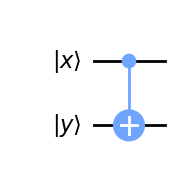

In [2]:
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)
# Aplica CNOT, primer parámetro target, segundo control
qc.cx(x,y)
qc.draw('mpl')

In [3]:
# Creo una funcion para obtener y 
# mostrar la matriz unitaria 
def obten_unitaria(qcirc, etiqueta):
    sim_u = AerSimulator(method='unitary')
    #Necesito indicar que se salve la matriz unitaria
    qcirc.save_unitary()

    result = execute(qcirc, sim_u).result()
    unitary = result.get_unitary(qcirc)
    array_to_latex(unitary, pretext=etiqueta)

In [4]:
obten_unitaria(qc, "U_{f_0} = ")

<IPython.core.display.Math object>

Qiskit permite definir este circuito como una puerta:

In [5]:
def f0_oraculo():
    """
    Define un oraculo para la funcion f0
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(2)
    # Aplica CNOT, primer parámetro target, segundo control
    qc.cx(0,1)
        
    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_0}$"
    return oraculo

### Demostración del paralelismo cuántico

Podemos ver como funciona el paralelismo cuántico haciendo un circuito en Qiskit con el oraculo asociado a $f_0$.

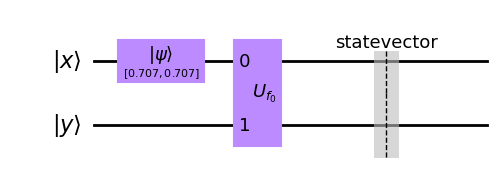

In [6]:
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)
estado_mas = Statevector([1/sqrt(2), 1/sqrt(2)])
qc.initialize(estado_mas,0)

# Añadimos el oráculo
qc = qc.compose(f0_oraculo())

#Indicamos que queremos ver el vector de estado en este punto
qc.save_statevector()
qc.draw('mpl')

In [7]:
# Ejecutamos una simulación 
job_sim = execute(qc, sim, shots=1)

# Obtenemos los resultados
result = job_sim.result()

# Obtenemos el vector de estado del circuito
estado = result.get_statevector()
# Muestra estado
array_to_latex(estado, pretext="|\psi\\rangle = ")

<IPython.core.display.Math object>

Se trata del estado:
$$
|\psi\rangle = \tfrac{1}{\sqrt{2}}(|00\rangle+|11\rangle) = \tfrac{1}{\sqrt{2}}(|f_0(0),0\rangle+|f_0(1),1\rangle)
$$

### Ejercicio 2

Crea funciones oráculo en Qiskit para las otras 3 matrices y prueba el paralelismo cuantico en los 3 casos.

**Matriz $f_1$**

Primero creamos el circuito para ver la matriz unitaria

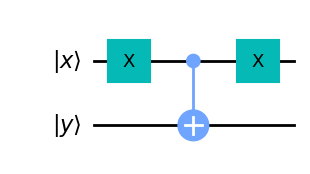

<IPython.core.display.Math object>

In [8]:
# Matriz f1
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)
# Aplica una NOT a x
qc.x(x)
# Aplica CNOT, primer parámetro target, segundo control
qc.cx(x,y)
# Recupera x
qc.x(x)
display(qc.draw('mpl'))
obten_unitaria(qc, "U_{f_0} = ")

Escribimos el circuito en forma de función oráculo

In [9]:
# Oraculo para f1
def f1_oraculo():
    """
    Define un oraculo para la funcion f1
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(2)
    # Aplica CNOT, primer parámetro target, segundo control
    qc.x(0)
    qc.cx(0,1)
    qc.x(0)
        
    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_1}$"
    return oraculo

Probamos el paralelismo cuántico con $|x\rangle$ en superposición.

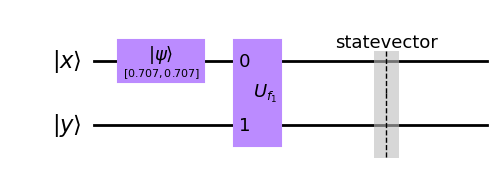

In [10]:
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)
estado_mas = Statevector([1/sqrt(2), 1/sqrt(2)])
qc.initialize(estado_mas,0)

# Añadimos el oráculo
qc = qc.compose(f1_oraculo())

#Indicamos que queremos ver el vector de estado en este punto
qc.save_statevector()
qc.draw('mpl')

In [11]:
# Ejecutamos una simulación 
job_sim = execute(qc, sim, shots=1)

# Obtenemos los resultados
result = job_sim.result()

# Obtenemos el vector de estado del circuito
estado = result.get_statevector()
# Muestra estado
array_to_latex(estado, pretext="|\psi\\rangle = ")

<IPython.core.display.Math object>

Se trata del estado:
$$
|\psi\rangle = \tfrac{1}{\sqrt{2}}(|01\rangle+|10\rangle) = \tfrac{1}{\sqrt{2}}(|f_1(1),1\rangle+|f_1(0),0\rangle)
$$

**Matriz $f_2$**

En este caso la matriz es la identidad, que corresponde a un circuito sin puertas.

Lo expresamos en forma de oráculo.

In [12]:
# Oraculo para f2 (Identidad)
def f2_oraculo():
    """
    Define un oraculo para la funcion f1
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(2)
        
    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_2}$"
    return oraculo

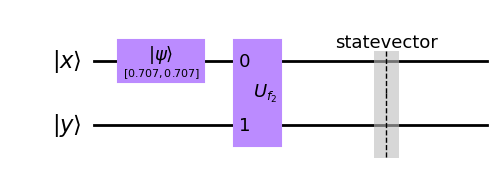

In [13]:
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)
estado_mas = Statevector([1/sqrt(2), 1/sqrt(2)])
qc.initialize(estado_mas,0)

# Añadimos el oraculo
qc = qc.compose(f2_oraculo())

#Indicamos que queremos ver el vector de estado en este punto
qc.save_statevector()
qc.draw('mpl')

In [14]:
# Ejecutamos una simulación 
job_sim = execute(qc, sim, shots=1)

# Obtenemos los resultados
result = job_sim.result()

# Obtenemos el vector de estado del circuito
estado = result.get_statevector()
# Muestra estado
array_to_latex(estado, pretext="|\psi\\rangle = ")

<IPython.core.display.Math object>

Se trata del estado:
$$
|\psi\rangle = \tfrac{1}{\sqrt{2}}(|00\rangle+|01\rangle) = \tfrac{1}{\sqrt{2}}(|f_2(0),0\rangle+|f_2(1),1\rangle)
$$

**Matriz $f_3$**

Primero creamos el circuito para ver la matriz unitaria.

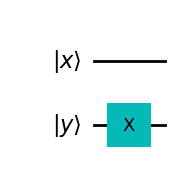

<IPython.core.display.Math object>

In [15]:
# Matriz f3
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)

qc.x(y)

display(qc.draw('mpl'))
obten_unitaria(qc, "U_{f_0} = ")

Lo expresamos en forma de oráculo

In [16]:
# Oraculo para f3
def f3_oraculo():
    """
    Define un oraculo para la funcion f3
        return: circuito de 2 cúbit en forma de puerta
    """
    qc = QuantumCircuit(2)
    # Aplica CNOT, primer parámetro target, segundo control
    qc.x(1)
        
    # Convierte el circuito en una puerta
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_3}$"
    return oraculo

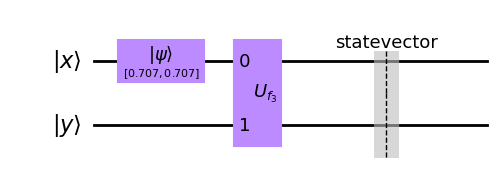

In [17]:
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)
estado_mas = Statevector([1/sqrt(2), 1/sqrt(2)])
qc.initialize(estado_mas,0)

# Añadimos el oráculo
qc = qc.compose(f3_oraculo())

#Indicamos que queremos ver el vector de estado en este punto
qc.save_statevector()
qc.draw('mpl')

In [18]:
# Ejecutamos una simulación 
job_sim = execute(qc, sim, shots=1)

# Obtenemos los resultados
result = job_sim.result()

# Obtenemos el vector de estado del circuito
estado = result.get_statevector()
# Muestra estado
array_to_latex(estado, pretext="|\psi\\rangle = ")

<IPython.core.display.Math object>

Se trata del estado:
$$
|\psi\rangle = \tfrac{1}{\sqrt{2}}(|10\rangle+|11\rangle) = \tfrac{1}{\sqrt{2}}(|f_3(0),0\rangle+|f_3(1),1\rangle)
$$

## Complejidad de consultas

En un algoritmo que hace uso de un oráculo, se denomina complejidad de consultas (*query complexity*) al número medio de *consultas* al oráculo que se necesitan para resolver el problema.

La complejidad se expresa a través de la *notación asintótica*, principalmente la notación *Big-O*.

Así, si el número $n$ de accesos al oráculo crece exponencialmente, la complejidad será $\mathcal{O}\left(2^n\right)$ y si lo hace linealmente $\mathcal{O}\left(n\right)$.

Los algoritmos cuánticos que veremos a continuación tienen una menor complejidad de consultas que sus equivalentes clásicos.

-------------------------------
-------------------------------
-------------------------------

# Algoritmo de Deutsch <a id="deutsch"></a>

Las funciones $f(x): \{0,1\}\rightarrow\{0,1\}$ se denominan:

- Constantes: si $f(0)=f(1)$
- Balanceadas: si $f(0)\ne f(1)$

De las 4 funciones anteriores, $f_0$ y $f_1$ son balanceadas mientras que $f_2$ y $f_3$ son constantes.

Dada una función $f(x): \{0,1\}\rightarrow\{0,1\}$ desconocida, un algoritmo clásico necesita 2 llamadas a $f$ para determinar si es constante o balanceada.

El **algoritmo cuántico de Deutsch** puede determinarlo con una sola llamada a $f$.

Partimos del circuito siguiente:

<img src="images/Deutsch.svg" alt="Tabla f0" style="width: 800px;"/>

Estado después de la puerta X:
$$
|\psi_0\rangle = |10\rangle 
$$

Estado despues de las H:
$$
|\psi_1\rangle = |-+\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}\otimes \frac{|0\rangle + |1\rangle}{\sqrt{2}} = |y\rangle \otimes|x\rangle 
$$

Y se tiene que:

$$
y\oplus f(x) = \frac{|0\rangle - |1\rangle}{\sqrt{2}}\oplus f(x) = \frac{|0\oplus f(x)\rangle - |1\oplus f(x)\rangle}{\sqrt{2}} = 
\begin{cases}
\frac{|0\rangle - |1\rangle}{\sqrt{2}}, & \text{si } f(x) = 0\\
\frac{|1\rangle - |0\rangle}{\sqrt{2}}, & \text{si } f(x) = 1
\end{cases}
$$

por lo que podemos escribir: 
$$
y\oplus f(x) = (-1)^{f(x)}\frac{|0\rangle - |1\rangle}{\sqrt{2}}
$$

De aquí se tiene que:

$$
|\psi_2\rangle = \frac{1}{\sqrt{2}}(-1)^{f(x)} (|0\rangle - |1\rangle)\otimes |x\rangle = 
\frac{1}{\sqrt{2}} (|0\rangle - |1\rangle)\otimes (-1)^{f(x)}|x\rangle
$$
Y podemos escribir:
$$
(-1)^{f(x)}|x\rangle = |(-1)^{f(x)}x\rangle = 
\frac{(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle}{\sqrt{2}}
$$

Por lo tanto, el estado $|\psi_2\rangle$ queda:
$$
|\psi_2\rangle = 
\frac{|0\rangle - |1\rangle}{\sqrt{2}}\otimes 
\frac{(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle}{\sqrt{2}} =
\begin{cases}
\pm\left[\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right] \otimes \left[\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right], & \text{si } f(0) = f(1)\\\mbox{}\\
\pm\left[\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right] \otimes  \left[\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right], & \text{si } f(0) \neq f(1)
\end{cases}
$$

Al aplicar la última `H`:

$$
|\psi_3\rangle = 
\begin{cases}
\pm\frac{|0\rangle - |1\rangle}{\sqrt{2}} \otimes |0\rangle, & \text{si } f(0) = f(1)\\\mbox{}\\
\pm\frac{|0\rangle - |1\rangle}{\sqrt{2}} \otimes |1\rangle, & \text{si } f(0) \neq f(1)
\end{cases}
$$

Midiendo el cúbit de arriba vamos a obtener, con total certeza, un $0$ si $f$ es constante o un $1$ si $f$ es balanceada, con una sola evaluacion de $f(x)$.

### Ejercicio 3

Implementa un circuito en Qiskit para probar el algoritmo de Deutsch con los oráculos definidos para las funciones $f_{0-3}$. Comprueba que es capaz de determinar si la función es constante o balanceada.

In [51]:
# Empieza creando un circuito a partir de un oráculo
def deutsch_qc(oraculo):
    x = QuantumRegister(1, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    meas = ClassicalRegister(1, name="Medida")
    qc = QuantumCircuit(x,y,meas)
    
    # Añade las puertas iniciales
    #qc.x(y)
    qc.h(x)
    qc.h(y)
    
    # Añade el oraculo
    qc = qc.compose(oraculo())
    
    # Añade la última puerta H
    #qc.h(x)
    
    # Añade la medida
    #qc.measure(x,meas)

    return qc

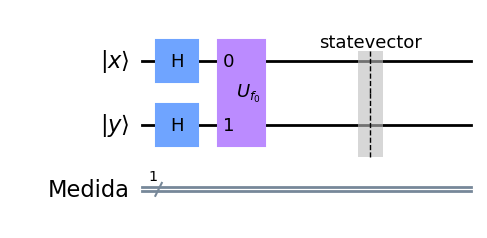

<IPython.core.display.Math object>

In [52]:
# Probamos con f0
qc = deutsch_qc(f0_oraculo)
qc.save_statevector()
display(qc.draw('mpl'))

# Ejecutamos una simulación 
job_sim = execute(qc, sim, shots=1)

# Obtenemos los resultados
result = job_sim.result()

# Obtenemos el vector de estado del circuito
estado = result.get_statevector()
# Muestra estado
array_to_latex(estado, pretext="|\psi\\rangle = ")

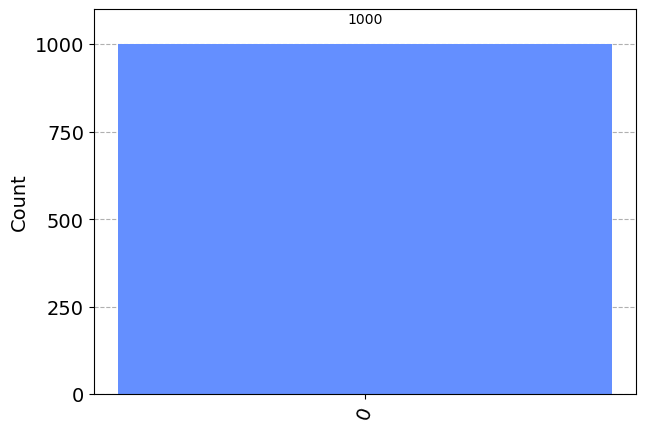

In [21]:
# Hacemos la simulacion
result = execute(qc, sim, shots = 1000).result()
salida = result.get_counts()
plot_histogram(salida)

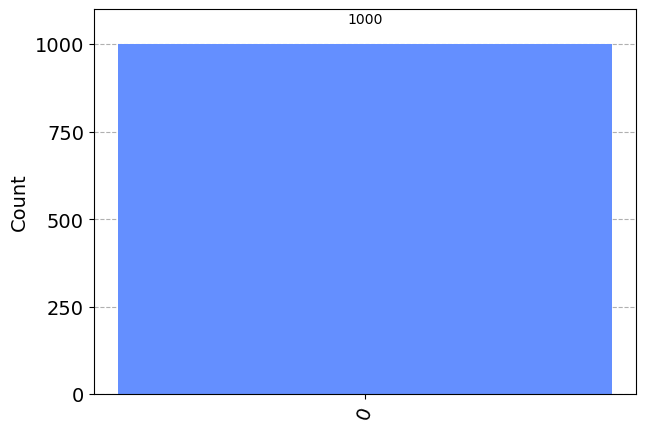

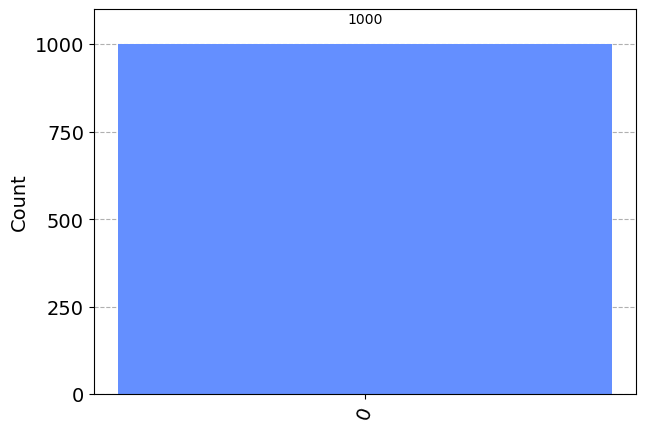

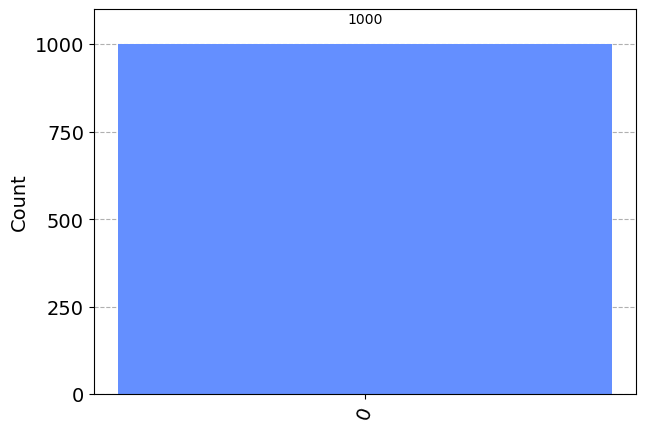

In [22]:
# Probamos con las otras 3
for f in [f1_oraculo, f2_oraculo, f3_oraculo]:
    qc = deutsch_qc(f)
    # hacemos la simulacion
    result = execute(qc, sim, shots = 1000).result()
    salida = result.get_counts()
    display(plot_histogram(salida))

# Algoritmo de Deutsch-Jozsa <a id="dj"></a>

Es una generalización a $n$ bits del anterior. Dada una función (oráculo) $f(\{x_{n-1},x_{n-2},\ldots,x_1,x_{0}\}) \rightarrow \{0,1\}$, que es, o bien, _balanceada_, o bien, _constante_, determinar el tipo:

- Función constante: la salida de $f(x)$ es, o bien, 0, o bien, 1 $\forall x$ 
- Función balanceada: devuelve 0 para la mitad de las entradas y 1 para la otra mitad

**Solución clásica**

Un algoritmo clásico necesita efectuar en el mejor caso $2$ y en el peor $2^{n-1}+1$ evaluaciones de $f(x)$, por lo que su complejidad es exponencial $\mathcal{O}(2^n)$.

**Solución cuántica**

El algoritmo cuántico ([D. Deutsch and R. Jozsa, 1992](https://doi.org/10.1098%2Frspa.1992.0167)) solo necesita una evaluación del oráculo $f(x)$ (ganancia exponencial).

El circuito usado es:

<img src="images/Deutsch-Jozsa.svg" alt="Deutsch-Jozsa" style="width: 800px;"/>


Pasos:

<ol>
   <li>
        Estado inicial:
        

$$\vert \psi_0 \rangle = \vert 1\rangle \vert0\rangle^{\otimes n} $$


   </li>
    
   <li>
        Después de aplicar las primeras puertas H:
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \left(|0\rangle - |1 \rangle \right)\vert x\rangle $$
   </li>
   <p>
   <li>
        Aplicamos $U_f$ a $\vert y\rangle \vert x\rangle$ para obtener $\vert y \oplus f(x)\rangle\vert x\rangle$, recordando que $y\oplus f(x) = \tfrac{1}{\sqrt{2}} (-1)^{f(x)}(|0\rangle - |1\rangle)$:
 
$$\vert\psi_2\rangle  = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}(|0\rangle - |1\rangle)|x\rangle=\frac{(|0\rangle - |1\rangle)}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle$$
          </li>
<p>
   <li>Ahora aplicamos una H a cada cúbit en  $|x\rangle$ (recordemos que $H^{\otimes n}|x\rangle = \tfrac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n-1} (-1)^{x\cdot i}|i\rangle)$. Si ya no consideramos el cúbit de abajo, el estado es:<p>
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{i=0}^{2^n-1}(-1)^{x \cdot i} 
                    \vert i \rangle \right] \\
                & = \frac{1}{2^n}\sum_{i=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot i} \right]
                    \vert i \rangle
        \end{aligned}
        $$
       
con $x \cdot i = x_{n-1}i_{n-1}\oplus x_{n-2}i_{n-2}\oplus \ldots \oplus x_1i_1 \oplus x_0i_0$.
   </li>

   <li>
       Se realiza la medida. La probabilidad de obtener todo 0 ($\vert i \rangle=  \vert 0 \rangle ^{\otimes n}$) es:
       $$
       \left| \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \right|^2 = 
       \begin{cases}
       1, \text{si } f \text{ es constante}\\
       0, \text{si } f \text{ es balanceada}
       \end{cases}
       $$
   </li>
<p>
</ol>
En conclusión, si a la salida obtenemos todo 0, $f$ es constante. Si obtenemos cualquier otro valor $f$ es balanceada. 

<p></p>

<details>
    <summary><p style="color:blue">Demostración de que $H^{\otimes n}|x\rangle = \tfrac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n-1} (-1)^{x\cdot i}|i\rangle$</p></summary>

El uso de puertas `H` permite poner los n-cúbits en un estado de superposición.

El estado de _superposición completa_ es:

$$
|+\rangle^{\otimes n} = H^{\otimes n}|0\rangle^{\otimes n}
$$

$H^{\otimes n}$ se conoce como puerta _Walsh-Hadamard_.

Ejemplo para 4 cúbits:

$$
H^{\otimes 4}|1010\rangle = H|1\rangle\otimes H|0\rangle\otimes H|1\rangle\otimes H|0\rangle = \\
\frac{1}{4}\left[(|0\rangle - |1\rangle)\otimes (|0\rangle + |1\rangle) \otimes (|0\rangle - |1\rangle) \otimes (|0\rangle + |1\rangle)\right] = \frac{1}{4}\left[\\
|0000\rangle+|0001\rangle-|0010\rangle-|0011\rangle+\\
|0100\rangle+|0101\rangle-|0110\rangle-|0111\rangle-\\
|1000\rangle-|1001\rangle+|1010\rangle+|1011\rangle-\\
|1100\rangle-|1101\rangle+|1110\rangle+|1111\rangle\phantom{-}\right]
$$

En este ejemplo, el signo negativo aparece en los estados $|x_3x_2x_1x_0\rangle$ para los que se verifica que:
    
$$
(x_3x_2x_1x_0)\cdot(1010) = x_3\cdot 1\oplus x_2\cdot 0 \oplus x_1\cdot 1 \oplus x_0\cdot 0 = x_3\cdot x_1 = 1
$$

que son los estados para los que $x_3 \ne x_1$.
    
En general, para un estado $|x\rangle = |x_{n-1}x_{n-2}\ldots x_0\rangle$ de n-cúbits, se puede escribir:

$$
H^{\otimes n}|x\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n-1} (-1)^{x\cdot i}|i\rangle
$$

siendo $x\cdot i = x_{n-1}i_{n-1}\oplus x_{n-2}i_{n-2}\oplus \ldots \oplus x_0i_0$

</details>


**Ejemplo**
Supongamos $n=2$. Las probabilidades asociadas a cada salida son:

$$
p(0) = \left|\frac{1}{4} \sum_{x=0}^{3}(-1)^{f(x)}(-1)^{x \cdot 0} \right|^2 = \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{0} + (-1)^{f(2)}(-1)^{0} + (-1)^{f(3)}(-1)^{0}\right]  \right|^2
$$
$$
p(1) = \left|\frac{1}{4} \sum_{x=0}^{3}(-1)^{f(x)}(-1)^{x \cdot 1} \right|^2 = \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{1} + (-1)^{f(2)}(-1)^{0} + (-1)^{f(3)}(-1)^{1}\right]  \right|^2
$$
$$
p(2) = \left|\frac{1}{4} \sum_{x=0}^{3}(-1)^{f(x)}(-1)^{x \cdot 2} \right|^2 = \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{0} + (-1)^{f(2)}(-1)^{1} + (-1)^{f(3)}(-1)^{1}\right]  \right|^2
$$
$$
p(3) = \left|\frac{1}{4} \sum_{x=0}^{3}(-1)^{f(x)}(-1)^{x \cdot 3} \right|^2 = \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{1} + (-1)^{f(2)}(-1)^{1} + (-1)^{f(3)}(-1)^{0}\right]  \right|^2
$$

Es fácil ver que si $f$ es constante, $p(0)=1$ y $p(1)=p(2)=p(3)=0$, ya que se anulan los términos. Por contra, si $f$ es balanceada $p(0)=0$.

### Ejercicio 4

Determina qué valor se va a medir si $f(0) = f(1) = 0$ y $f(2) = f(3) = 1$.

Tenemos:

$$
\begin{align}
p(0) &= \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{0} + (-1)^{f(2)}(-1)^{0} + (-1)^{f(3)}(-1)^{0}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{f(0)} + (-1)^{f(1)} + (-1)^{f(2)} + (-1)^{f(3)}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{0} + (-1)^{0} + (-1)^{1} + (-1)^{1}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ 1 + 1 -1 -1\right]  \right|^2 = 0
\end{align}
$$

$$
\begin{align}
p(1) &= \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{1} + (-1)^{f(2)}(-1)^{0} + (-1)^{f(3)}(-1)^{1}\right]  \right|^2 \\
&= \left|\frac{1}{4} \left[ (-1)^{f(0)} - (-1)^{f(1)} + (-1)^{f(2)} - (-1)^{f(3)}\right]  \right|^2 \\
&= \left|\frac{1}{4} \left[ (-1)^{0} - (-1)^{0} + (-1)^{1} - (-1)^{1}\right]  \right|^2 \\
&= \left|\frac{1}{4} \left[ 1 - 1 -1 +1\right]  \right|^2 = 0
\end{align}
$$

$$
\begin{align}
p(2) &= \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{0} + (-1)^{f(2)}(-1)^{1} + (-1)^{f(3)}(-1)^{1}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{f(0)} + (-1)^{f(1)} - (-1)^{f(2)} - (-1)^{f(3)}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{0} + (-1)^{0} - (-1)^{1} - (-1)^{1}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ 1 + 1 +1 +1 \right]  \right|^2 = 1
\end{align}
$$

$$
\begin{align}
p(3) &= \left|\frac{1}{4} \left[ (-1)^{f(0)}(-1)^{0} + (-1)^{f(1)}(-1)^{1} + (-1)^{f(2)}(-1)^{1} + (-1)^{f(3)}(-1)^{0}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{f(0)} - (-1)^{f(1)} - (-1)^{f(2)} + (-1)^{f(3)}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{0} - (-1)^{0} - (-1)^{1} + (-1)^{1}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ 1 - 1 + 1 - 1\right]  \right|^2 = 0
\end{align}
$$

Se obtiene un 2 con 100% de probabilidad.

Ejemplo: ¿Qué pasa si f(0)=1 y f(1)=f(2)=f(3)=0?

$$
\begin{align}
p(0) 
&= \left|\frac{1}{4} \left[ (-1)^{f(0)} + (-1)^{f(1)} + (-1)^{f(2)} + (-1)^{f(3)}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{1} + (-1)^{0} + (-1)^{0} + (-1)^{0}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ -1 + 1 +1 +1\right]  \right|^2 = \frac{1}{4}
\end{align}
$$

$$
\begin{align}
p(1) 
&= \left|\frac{1}{4} \left[ (-1)^{f(0)} - (-1)^{f(1)} + (-1)^{f(2)} - (-1)^{f(3)}\right]  \right|^2 \\
&= \left|\frac{1}{4} \left[ (-1)^{1} - (-1)^{0} + (-1)^{0} - (-1)^{0}\right]  \right|^2 \\
&= \left|\frac{1}{4} \left[ -1 - 1 + 1 -1\right]  \right|^2 = \frac{1}{4}
\end{align}
$$

$$
\begin{align}
p(2) 
&= \left|\frac{1}{4} \left[ (-1)^{f(0)} + (-1)^{f(1)} - (-1)^{f(2)} - (-1)^{f(3)}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{1} + (-1)^{0} - (-1)^{0} - (-1)^{0}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ -1 + 1 -1 -1 \right]  \right|^2 = \frac{1}{4}
\end{align}
$$

$$
\begin{align}
p(3) 
&= \left|\frac{1}{4} \left[ (-1)^{f(0)} - (-1)^{f(1)} - (-1)^{f(2)} + (-1)^{f(3)}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ (-1)^{1} - (-1)^{0} - (-1)^{0} + (-1)^{0}\right]  \right|^2\\
&= \left|\frac{1}{4} \left[ -1 - 1 - 1 + 1\right]  \right|^2 = \frac{1}{4}
\end{align}
$$

In [23]:
def prod(a,b):
    # Devuelve el producto a_n-1⊕b𝑛−1⊕...⊕a_0b0
    return(((a&b).bit_count())&1)

In [24]:
def prob(i, f, nbits):
    # Devuelve la probabilidad para un |i> 
    powmenos1 = [1,-1]
    #N = pow(2,n)
    N = 1<<nbits
    p = 0
    for x in range(N):
        xi = prod(x,i)
        #p += pow(-1,f[x])*pow(-1,xi)
        p += powmenos1[f[x]]*powmenos1[xi]
    # Divido p entre 2^n
    p = p / N
    return(p*p)    

In [25]:
nbits = 2
funcs = [1,1,1,1]

probs = [prob(i,funcs,nbits) for i in range(1<<nbits)]

print(probs)
    

[1.0, 0.0, 0.0, 0.0]


In [26]:
nbits = 10
funcs = [0 for i in range(1<<nbits)]
funcs[352] = 1
funcs[35] = 1
funcs[2] = 1
funcs[1000] = 1

probs = [prob(i,funcs,nbits) for i in range(1<<nbits)]

print(probs)

[0.98443603515625, 1.52587890625e-05, 0.0, 1.52587890625e-05, 6.103515625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 6.103515625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 6.103515625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 6.103515625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 6.103515625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 6.103515625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 6.103515625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 0.0, 1.52587890625e-05, 6.103515625e-05, 1.52587890625e-05, 0.0, 1.52587890625e-05, 6.103515625e-05, 1.52587890625e-05, 1.52587890625e

-----------------------
--------------------
--------------------------

# Algoritmo de Bernstein-Vazirani <a id="bv"></a>

Es una versión del anterior en la que el oráculo $f(\{x_{n-1},x_{n-2},\ldots,x_{0}\}) \rightarrow \{0,1\}$ es de la forma $f_s(x) = s\cdot x = s_{n-1}x_{n-1} \oplus s_{n-2}x_{n-2} \oplus \ldots \oplus s_{0}x_{0}$, con $s_i\in\{0,1\}$, donde $s$ es desconocido. El objetivo es encontrar el valor de $s$.

**Solución clásica**

Para obtener $s$, un algoritmo clásico tiene que hacer $n$ invocaciones de $f_s(x)$ con los valores $x=2^i$ con $i \in \{0,\ldots,n-1\}$.

$$
s_0 = f_s(000\ldots 01)\\
s_1 = f_s(000\ldots 10)\\
\cdots\\
s_{n-1} = f_s(100\ldots 00)
$$

**Solución cuántica**

El algoritmo cuántico ([E. Bernstein y U. Vazirani, 1997](https://doi.org/10.1137/S0097539796300921)) necesita 1 sola invocación del oráculo.

El circuito es idéntico al de Deutsch-Jozsa, solo cambia la función oráculo. 

Al igual que antes tenemos:

$$            
\lvert \psi_3 \rangle  = \frac{1}{2^n}\sum_{i=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f_s(x)}(-1)^{x \cdot i} \right]
                    \vert i \rangle = 
                    \frac{1}{2^n}\sum_{i=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{s\cdot x}(-1)^{x \cdot i} \right]
                    \vert i \rangle = 
                    \sum_{i=0}^{2^n-1}
                    \left[ \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{s\cdot x}(-1)^{x \cdot i} \right]
$$

El sumatorio sobre $x$ se puede escribir:

$$
\frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{s\cdot x}(-1)^{x \cdot i} = \frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{(s\cdot x) \oplus (x \cdot i)} = \frac{1}{2^n} \sum_{x=0}^{2^n-1}(-1)^{(s \oplus i)\cdot x}
=
       \begin{cases}
       1, \text{si } s \oplus i = 0\\
       0, \text{si } s \oplus i = 1
       \end{cases}
$$                    

Y $s \oplus i = 0 \Rightarrow s = i$, es decir, que la amplitud no nula es, precisamente, $|s\rangle$.

**Ejemplo**: supongamos $n=2$. Aplicando el algoritmo tenemos en el paso 2:

$$
\lvert \psi_2 \rangle  
    = \frac{|0\rangle - |1\rangle}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle
    = \frac{|0\rangle - |1\rangle}{2\sqrt{2}}
                 \left[ 
                 (-1)^{s\cdot 00}|00\rangle + 
                 (-1)^{s\cdot 01}|01\rangle + 
                 (-1)^{s\cdot 10}|10\rangle + 
                 (-1)^{s\cdot 11}|11\rangle\right]
$$

Si suponemos $s=11$, el estado será:

$$
\lvert \psi_2 \rangle =   \frac{|0\rangle - |1\rangle}{2\sqrt{2}}
                 \left[ 
                 (-1)^{11\cdot 00}|00\rangle + 
                 (-1)^{11\cdot 01}|01\rangle + 
                 (-1)^{11\cdot 10}|10\rangle + 
                 (-1)^{11\cdot 11}|11\rangle\right] = 
                 \frac{1}{2}(|00\rangle - |01\rangle - |10\rangle + |11\rangle)
$$

Y al aplicar las `H`:

$$
\lvert \psi_3 \rangle =   \frac{1}{4}\left[
(|0\rangle+|1\rangle)\otimes(|0\rangle+|1\rangle) -
(|0\rangle+|1\rangle)\otimes(|0\rangle-|1\rangle) -
(|0\rangle-|1\rangle)\otimes(|0\rangle+|1\rangle) +
(|0\rangle-|1\rangle)\otimes(|0\rangle-|1\rangle)
\right] = \\
= \frac{1}{4}\left[
|00\rangle + |01\rangle + |10\rangle + |11\rangle - |00\rangle + |01\rangle - |10\rangle + |11\rangle  
- |00\rangle - |01\rangle + |10\rangle + |11\rangle + |00\rangle - |01\rangle - |10\rangle + |11\rangle
\right] = \\
= |11\rangle = |s\rangle
$$

### Ejercicio 5

Implementa un oráculo para el algoritmo de Bernstein-Vazirani con $n$ bits y $s$ aleatoria.

In [27]:
# Obtenemos s como una lista de valores binarios aleatoria
def get_s(n):
    s = list()
    for q in range(n):
        if np.random.randint(2) == 1:
            s.append(1)
        else:
            s.append(0)
    return(s)

In [28]:
def bv_oraculo(n):
    """
    Devuelve un oraculo para el algoritmo de Bernstein-Vazirani 
    
        n: Número de cúbits de entrada
        return: circuito de n+1 cúbit en forma de puerta
    """
    x = QuantumRegister(n, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x,y)
    s = get_s(n)
    
    # El oráculo puede implementarse con puertas CNOT controladas
    # por los cúbits para los que el bit en s vale 1
    
    sinv = s[::-1] # Invertimos s para recorrerlo del bit menos al más significativo
    
    for q in range(n):
        if sinv[q] == 1:
            bv_oraculo.cx(q,n)
            
    # Salida
    oraculo = qc.to_gate()
    oraculo.name = "$U_{f}$"
    return oraculo

------------------------------
--------------------------
----------------------------

# Algoritmo de periodicidad de Simon <a id="simon"></a>

En este caso, el oráculo es una función $f_c:\{0,1\}^n \rightarrow \{0,1\}^n$ que depende de un número binario desconocido $c=c_{n-1}c_{n-2}\ldots c_0 \ne 0$, con $c_i \in \{0,1\}$, tal que, para todos los valores $x,y \in \{0,1\}^n$ se tiene que:
$$
f_c(x) = f_c(y) \Leftrightarrow y=x\oplus c \text{   (o que }x\oplus y =c\text{)}
$$

Es decir, los valores de $f_c$ se repiten con un cierto patrón dado por $c$, que se denomina período. Por ejemplo, supongamos $n=3$ y $c=5\equiv 101$:

$$
\hphantom{00} x\hphantom{0 \oplus 1} c \hphantom{01 = 1} y\hphantom{01 \Rightarrow f_c(0) = f_c(5)}\\
000 \oplus 101 = 101 \Rightarrow f_c(0) = f_c(5)\\
001 \oplus 101 = 100 \Rightarrow f_c(1) = f_c(4)\\
010 \oplus 101 = 111 \Rightarrow f_c(2) = f_c(7)\\
011 \oplus 101 = 110 \Rightarrow f_c(3) = f_c(6)\\
100 \oplus 101 = 001 \Rightarrow f_c(4) = f_c(1)\\
101 \oplus 101 = 000 \Rightarrow f_c(5) = f_c(0)\\
110 \oplus 101 = 011 \Rightarrow f_c(6) = f_c(3)\\
111 \oplus 101 = 010 \Rightarrow f_c(7) = f_c(2)
$$

**Solución clásica**

Un algoritmo clásico necesita evaluar la función hasta encontrar dos valores $x$ e $y$ tales que $f_c(x) = f_c(y)$. Dados esos valores, se tiene que $c=x\oplus y$.

En el peor de los casos tenemos que buscar en la mitad de los valores, efectuando $2^{n-1}+1$ evaluaciones de $f(x)$.

**Solución cuántica**

El algoritmo cuántico ([D. R. Simon, 1997](https://doi.org/10.1137/S0097539796298637)) solo necesita $n$ evaluaciones.

El circuito que se utiliza es similar al que venimos usando pero con $n$ bits de ancilla:

<img src="images/Simon.svg" alt="Simon" style="width: 800px;"/>


Pasos:

<ol>
   <li>
        Estado inicial:
        

$$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 0\rangle^{\otimes n}$$


   </li>
    
   <li>
        Después de aplicar las primeras puertas H:
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|0\rangle \vert x\rangle$$
   </li>
   <p>
   <li>
        Aplicamos $U_f$ a $\vert y\rangle\vert x\rangle$ para obtener $\vert y \oplus f(x)\rangle\vert x\rangle$:
        $$
            \lvert \psi_2 \rangle  
                 = \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|0\oplus f(x)\rangle|x\rangle =  
                 \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1}|f(x)\rangle|x\rangle
        $$
          </li>
<p>
   <li>Ahora aplicamos una H a cada cúbit en  $|x\rangle$ (recordemos que $H^{\otimes n}|x\rangle = \frac{1}{\sqrt{2^n}} \sum_{i=0}^{2^n-1} (-1)^{x\cdot i}|i\rangle)$<p>
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle 
                 = \frac{1}{2^n} \sum_{x=0}^{2^n-1}|f(x)\rangle \sum_{i=0}^{2^n-1}(-1)^{x \cdot i} \vert i \rangle
                 = \frac{1}{2^n}\sum_{x=0}^{2^n-1}
                    \left[ \sum_{i=0}^{2^n-1}(-1)^{x \cdot i} 
                    \vert f(x) \rangle \vert i \rangle \right]
        \end{aligned}
        $$
          </li><br>
</ol>

Sabemos que para cada $\vert x \rangle$ y para cada $\vert i \rangle$ se verifica que $\vert f(x) \rangle\vert i \rangle = \vert f(x\oplus c) \rangle\vert i \rangle$. Para un par de este tipo, los sumandos son:

$$
\frac{(-1)^{x \cdot i} + (-1)^{(x\oplus c) \cdot i}}{2^n}\vert f(x) \rangle\vert i \rangle = 
\frac{(-1)^{x \cdot i} + (-1)^{(x\cdot i)\oplus (c\cdot i)}}{2^n}\vert f(x)\rangle\vert i\rangle =
\frac{(-1)^{x \cdot i}[1+(-1)^{c \cdot i}]}{2^n}\vert f(x)\rangle\vert i\rangle
$$

Así, si $c \cdot i = 1$ el termino correspondiente a $\vert f(x)\rangle\vert i\rangle$ se anula, y solo quedan los terminos para los que $c \cdot i = 0$.

Repitiendo varias veces la medida, podemos encontrar diferentes valores de $|i\rangle$ y, a partir de esas ecuaciones, obtener $c$.

**Ejemplo**

Supongamos $f:\{0,1\}^3 \rightarrow \{0,1\}^3$ tal que:
$$
f(0) = f(5) = 4\\
f(1) = f(4) = 1\\
f(2) = f(7) = 5\\
f(3) = f(6) = 7
$$

Es fácil comprobar que $f$ cumple los requisitos para aplicar el algoritmo de Simon.

Aplicando los pasos anteriores, en el paso 3 tenemos:

   
       
$$
\lvert \psi_3 \rangle 
                 = \frac{1}{8}\sum_{x=0}^{7}
                    \sum_{i=0}^{7}(-1)^{x \cdot i} 
                    \vert f(x)\rangle\vert i\rangle = 
                    \frac{1}{8}[\\
|f(0)\rangle|0\rangle +  |f(0)\rangle|1\rangle +  |f(0)\rangle|2\rangle +  |f(0)\rangle|3\rangle + \\ 
|f(0)\rangle|4\rangle +  |f(0)\rangle|5\rangle +  |f(0)\rangle|6\rangle +  |f(0)\rangle|7\rangle +\\[5pt]
|f(1)\rangle|0\rangle -  |f(1)\rangle|1\rangle +  |f(1)\rangle|2\rangle -  |f(1)\rangle|3\rangle + \\ 
|f(1)\rangle|4\rangle -  |f(1)\rangle|5\rangle +  |f(1)\rangle|6\rangle -  |f(1)\rangle|7\rangle +\\[5pt]
|f(2)\rangle|0\rangle +  |f(2)\rangle|1\rangle -  |f(2)\rangle|2\rangle -  |f(2)\rangle|3\rangle + \\ 
|f(2)\rangle|4\rangle +  |f(2)\rangle|5\rangle -  |f(2)\rangle|6\rangle -  |f(2)\rangle|7\rangle +\\[5pt]
|f(3)\rangle|0\rangle -  |f(3)\rangle|1\rangle -  |f(3)\rangle|2\rangle +  |f(3)\rangle|3\rangle + \\ 
|f(3)\rangle|4\rangle -  |f(3)\rangle|5\rangle -  |f(3)\rangle|6\rangle +  |f(3)\rangle|7\rangle +\\[5pt]
|f(4)\rangle|0\rangle +  |f(4)\rangle|1\rangle +  |f(4)\rangle|2\rangle +  |f(4)\rangle|3\rangle - \\ 
|f(4)\rangle|4\rangle -  |f(4)\rangle|5\rangle -  |f(4)\rangle|6\rangle -  |f(4)\rangle|7\rangle +\\[5pt]
|f(5)\rangle|0\rangle -  |f(5)\rangle|1\rangle +  |f(5)\rangle|2\rangle -  |f(5)\rangle|3\rangle - \\ 
|f(5)\rangle|4\rangle +  |f(5)\rangle|5\rangle -  |f(5)\rangle|6\rangle +  |f(5)\rangle|7\rangle +\\[5pt]
|f(6)\rangle|0\rangle +  |f(6)\rangle|1\rangle -  |f(6)\rangle|2\rangle -  |f(6)\rangle|3\rangle - \\ 
|f(6)\rangle|4\rangle -  |f(6)\rangle|5\rangle +  |f(6)\rangle|6\rangle +  |f(6)\rangle|7\rangle +\\[5pt]
|f(7)\rangle|0\rangle -  |f(7)\rangle|1\rangle -  |f(7)\rangle|2\rangle +  |f(7)\rangle|3\rangle - \\ 
|f(7)\rangle|4\rangle +  |f(7)\rangle|5\rangle +  |f(7)\rangle|6\rangle -  |f(7)\rangle|7\rangle\ ]
$$

Substituyendo los valores de $f$:

$$
\lvert \psi_3 \rangle = \frac{1}{8}[\\
|4\rangle|0\rangle +  |4\rangle|1\rangle +  |4\rangle|2\rangle +  |4\rangle|3\rangle +  
|4\rangle|4\rangle +  |4\rangle|5\rangle +  |4\rangle|6\rangle +  |4\rangle|7\rangle +\\[5pt]
|1\rangle|0\rangle -  |1\rangle|1\rangle +  |1\rangle|2\rangle -  |1\rangle|3\rangle +  
|1\rangle|4\rangle -  |1\rangle|5\rangle +  |1\rangle|6\rangle -  |1\rangle|7\rangle +\\[5pt]
|5\rangle|0\rangle +  |5\rangle|1\rangle -  |5\rangle|2\rangle -  |5\rangle|3\rangle +  
|5\rangle|4\rangle +  |5\rangle|5\rangle -  |5\rangle|6\rangle -  |5\rangle|7\rangle +\\[5pt]
|7\rangle|0\rangle -  |7\rangle|1\rangle -  |7\rangle|2\rangle +  |7\rangle|3\rangle +  
|7\rangle|4\rangle -  |7\rangle|5\rangle -  |7\rangle|6\rangle +  |7\rangle|7\rangle +\\[5pt]
|1\rangle|0\rangle +  |1\rangle|1\rangle +  |1\rangle|2\rangle +  |1\rangle|3\rangle -  
|1\rangle|4\rangle -  |1\rangle|5\rangle -  |1\rangle|6\rangle -  |1\rangle|7\rangle +\\[5pt]
|4\rangle|0\rangle -  |4\rangle|1\rangle +  |4\rangle|2\rangle -  |4\rangle|3\rangle -  
|4\rangle|4\rangle +  |4\rangle|5\rangle -  |4\rangle|6\rangle +  |4\rangle|7\rangle +\\[5pt]
|7\rangle|0\rangle +  |7\rangle|1\rangle -  |7\rangle|2\rangle -  |7\rangle|3\rangle -  
|7\rangle|4\rangle -  |7\rangle|5\rangle +  |7\rangle|6\rangle +  |7\rangle|7\rangle +\\[5pt]
|5\rangle|0\rangle -  |5\rangle|1\rangle -  |5\rangle|2\rangle +  |5\rangle|3\rangle -  
|5\rangle|4\rangle +  |5\rangle|5\rangle +  |5\rangle|6\rangle -  |5\rangle|7\rangle\ ]
$$

Simplificando:
$$
\lvert \psi_3 \rangle = \frac{1}{4}\left[\\
|4\rangle|0\rangle+|1\rangle|0\rangle+|5\rangle|0\rangle+|7\rangle|0\rangle+\\
|4\rangle|2\rangle+|1\rangle|2\rangle-|5\rangle|2\rangle-|7\rangle|2\rangle+\\
|4\rangle|5\rangle-|1\rangle|5\rangle+|5\rangle|5\rangle-|7\rangle|5\rangle+\\
|4\rangle|7\rangle-|1\rangle|7\rangle-|5\rangle|7\rangle+|7\rangle|7\rangle\ \right]
$$

Que podemos escribir como:
$$
\lvert \psi_3 \rangle = \frac{1}{4}\left[\\
(|4\rangle+|1\rangle+|5\rangle+|7\rangle) \otimes|0\rangle+\\
(|4\rangle+|1\rangle-|5\rangle-|7\rangle)\otimes|2\rangle+\\
(|4\rangle-|1\rangle+|5\rangle-|7\rangle)\otimes|5\rangle+\\
(|4\rangle-|1\rangle-|5\rangle+|7\rangle)\otimes|7\rangle\ \right]
$$

Al medir los 3 bits $|x\rangle$ obtenemos, con igual probabilidad, $|000\rangle$, $|010\rangle$, $|101\rangle$ o $|111\rangle$. Para esos valores, su producto bit a bit por $c$ (módulo 2) da 0, por lo que tenemos, si $c=c_2c_1c_0$, con $c_i\in \{0,1\}$, las siguientes ecuaciones:

i. $|000\rangle\cdot c = 0\cdot c_2\oplus 0\cdot c_1 \oplus 0\cdot c_0 = 0$

ii. $|010\rangle\cdot c = 0\cdot c_2\oplus 1\cdot c_1 \oplus 0\cdot c_0 = 0$

iii. $|101\rangle\cdot c = 1\cdot c_2\oplus 0\cdot c_1 \oplus 1\cdot c_0 = 0$

iv. $|111\rangle\cdot c = 1\cdot c_2\oplus 1\cdot c_1 \oplus 1\cdot c_0 = 0$

la ecuación (ii) indica que $c_1 = 0$, la (iii) que $c_2\oplus c_0 =0$ y la (iv) que $c_2\oplus c_1 \oplus c_0 =0$. Las únicas opciones para $c$ son $000$ o $101$, y como $c\neq 0$, tenemos que $c=5$.

### Ejercicio 6

Usamos el algoritmo de Simon para $n=3$ y obtenemos a la salida los siguientes estados: $|000\rangle$, $|001\rangle$, $|110\rangle$ y $|111\rangle$. ¿Cuánto vale $c$?

i. $|000\rangle\cdot c = 0\cdot c_2\oplus 0\cdot c_1 \oplus 0\cdot c_0 = 0$

ii. $|001\rangle\cdot c = 0\cdot c_2\oplus 0\cdot c_1 \oplus 1\cdot c_0 = 0$

iii. $|110\rangle\cdot c = 1\cdot c_2\oplus 1\cdot c_1 \oplus 0\cdot c_0 = 0$

iv. $|111\rangle\cdot c = 1\cdot c_2\oplus 1\cdot c_1 \oplus 1\cdot c_0 = 0$

la ecuación (ii) indica que $c_0 = 0$ y la (iii) y la (iv) que $c_2\oplus c_1 =0$. Las únicas opciones para $c$ son $000$ o $110$, y como $c\neq 0$, tenemos que $c=6$.

### Oráculo para el algoritmo de Simon

Supongamos $n=3$ y $c=110$. Una posible función es la siguiente:

$$
f(000) = f(110) = 000\\
f(001) = f(111) = 001\\
f(010) = f(100) = 100\\
f(011) = f(101) = 101
$$

Esta función se define como sigue. Sea $i$ la posición del bit a 1 menos significativo de $c$ (en el ejemplo, $i=1$). Definimos f como:

$$
f(x) = 
\begin{cases}
x \text{, si } x_i = 0\\
x\oplus c \text{, si } x_i = 1
\end{cases}
$$

Para implementar esa función podemos hacer lo siguiente:

1. Copiamos el valor de $|x\rangle$ en los cúbits de ancilla para tener $|x\rangle|x\rangle$.
2. Sea $i$ la posición del bit a 1 menos significativo de $c$. Usamos puertas CNOT con:
   - Cúbit de control: $x_i$
   - Cúbits target: todas las ancillas con $j\ge i$ para las $j$ que verifiquen que $c_j = 1$.
3. Adicionalmente, se pueden permutar e invertir las ancillas para introducir variabilidad.

In [29]:
# Ejemplo de oráculo para n=3 y c=110
# init es el valor inicial del registro x
def simon_oraculo_simple(init):
    x = QuantumRegister(3, name="|x\\rangle")
    ancilla = QuantumRegister(3, name="|ancilla\\rangle")
    meas = ClassicalRegister(3, name="Medida")
    qc = QuantumCircuit(x, ancilla, meas)
    qc.initialize(init)

    # Hacemos la copia de la x a las ancillas
    qc.cnot(x,ancilla)

    qc.barrier()

    qc.cnot(x[1],ancilla[1])
    qc.cnot(x[1],ancilla[2])

    qc.barrier()

    qc.measure(ancilla, meas)
    return(qc)

/tmp/ipykernel_27243/602884574.py:11: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x,ancilla)
/tmp/ipykernel_27243/602884574.py:15: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x[1],ancilla[1])
/tmp/ipykernel_27243/602884574.py:16: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x[1],ancilla[2])
/home/jorge.vazquez.perez/miniconda3/envs/basic-quantum/lib/python3.10/site-packages/qiskit/visualization/

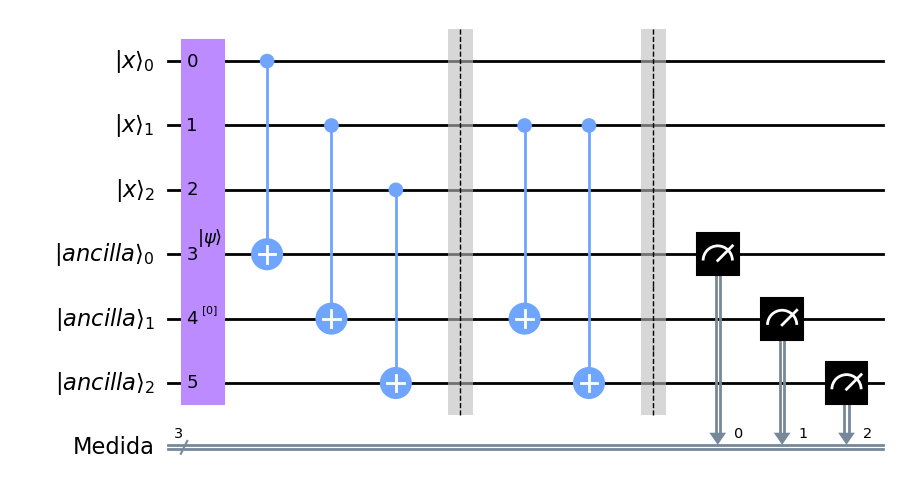

In [30]:
qc = simon_oraculo_simple(0)
qc.draw('mpl')

In [31]:
# Probamos para diferentes valores
for x in range(8):
    qc = simon_oraculo_simple(x)
    # Ejecutamos una simulación para obtener el vector de estado
    job_sim = execute(qc, sim, shots=1)

    # Obtenemos los resultados
    salida = job_sim.result().get_counts()

    print('f({0:03b}) = {1}'.format(x,list(salida.keys())[0]))

f(000) = 000
f(001) = 001
f(010) = 100
f(011) = 101
f(100) = 100
f(101) = 101
f(110) = 000
f(111) = 001


/tmp/ipykernel_27243/602884574.py:11: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x,ancilla)
/tmp/ipykernel_27243/602884574.py:15: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x[1],ancilla[1])
/tmp/ipykernel_27243/602884574.py:16: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x[1],ancilla[2])


### Ejercicio 7

Programa en Qiskit un oráculo para el algoritmo de Simon que implemente la función:$f:\{0,1\}^3 \rightarrow \{0,1\}^3$ tal que:

$$
f(0) = f(5) = 4\\
f(1) = f(4) = 5\\
f(2) = f(7) = 6\\
f(3) = f(6) = 7
$$

In [32]:
# Esa función corresponde a un c=101, por lo que el circuito inicial quedaría
def simon_oraculo_simple(init):
    x = QuantumRegister(3, name="|x\\rangle")
    ancilla = QuantumRegister(3, name="|ancilla\\rangle")
    meas = ClassicalRegister(3, name="Medida")
    qc = QuantumCircuit(x, ancilla, meas)
    qc.initialize(init)

    # Hacemos la copia de la x a las ancillas
    qc.cnot(x,ancilla)

    qc.barrier()

    qc.cnot(x[0],ancilla[0])
    qc.cnot(x[0],ancilla[2])

    qc.barrier()
    
    # Añadimos estos cambios para obtener los resultados que piden
    qc.swap(ancilla[0], ancilla[2])
    qc.x(ancilla[2])
    
    qc.measure(ancilla, meas)
    return(qc)

/tmp/ipykernel_27243/1164108710.py:10: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x,ancilla)
/tmp/ipykernel_27243/1164108710.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x[0],ancilla[0])
/tmp/ipykernel_27243/1164108710.py:15: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x[0],ancilla[2])


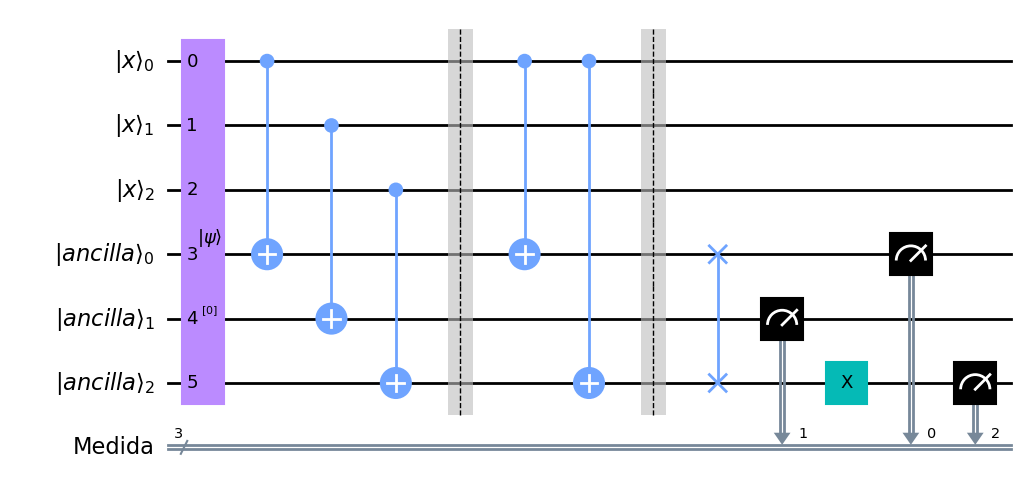

In [33]:
qc = simon_oraculo_simple(0)
qc.draw('mpl')

In [34]:
# Probamos para diferentes valores
for x in range(8):
    qc = simon_oraculo_simple(x)
    # Ejecutamos una simulación para obtener el vector de estado
    job_sim = execute(qc, sim, shots=1)

    # Obtenemos los resultados
    salida = job_sim.result().get_counts()

    print('f({0}) = {1}'.format(x,list(salida.keys())[0]))

f(0) = 100
f(1) = 101
f(2) = 110
f(3) = 111
f(4) = 101
f(5) = 100
f(6) = 111
f(7) = 110


/tmp/ipykernel_27243/1164108710.py:10: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x,ancilla)
/tmp/ipykernel_27243/1164108710.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x[0],ancilla[0])
/tmp/ipykernel_27243/1164108710.py:15: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(x[0],ancilla[2])


-------------------------
--------------------
-------------------

# Algoritmo de búsqueda de Grover: amplificación de amplitud <a id="grover"></a>

Este algoritmo busca un dato en una lista no estructurada.

El oráculo $f:\{0,1\}^n \rightarrow \{0,1\}$ es tal que existe un único $x_i$ tal que:
$$
f(x) = 
\begin{cases}
1, \text{si } x=x_i\\
0, \text{si } x\ne x_i
\end{cases}
$$

Buscamos $x_i$.

**Nota**: Es posible generalizar el algoritmo para cuando existe más de un dato $x_i$

**Solución clásica**

Si $N=2^n$ es el número de datos en la lista, un algoritmo clásico necesita efectuar, en el peor de los casos $N$ evaluaciones de $f(x)$, y de media $N/2$, por lo que la complejidad es $\mathcal{O}(2^n)$

**Solución cuántica**

El algoritmo cuántico ([L. K. Grover, 1996](http://doi.acm.org/10.1145/237814.237866)) solo necesita $\mathcal{O}\left(\sqrt{2^n}\right)$ evaluaciones.

El algoritmo tiene dos partes:

### Inversión de fase

Mediante el siguiente circuito invertimos la fase de $|x_i\rangle$:

<img src="images/Grover1.svg" alt="Grover inversion de fase" style="width: 600px;"/>


Pasos:

<ol>
   <li>
        Estado inicial:
        

$$\vert \psi_0 \rangle =  \vert1\rangle\vert0\rangle^{\otimes n}$$


   </li>
    
   <li>
        Después de aplicar las primeras puertas H:
$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} (|0\rangle-|1\rangle)\vert x\rangle $$
   </li>
   <p>
   <li>
        Aplicamos $U_f$ a $\vert y\rangle\vert x\rangle$ para obtener $\vert y \oplus f(x)\rangle\vert x\rangle$:
        $$
            \lvert \psi_2 \rangle  
                 = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle)|x\rangle
        $$
          </li>
<p>
   <li>Como $f(x) = 1$ si $x = x_i$ y $f(x)=0$ en otro caso podemos escribir:
$$
\begin{aligned}
\lvert \psi_2 \rangle  
&= \frac{1}{\sqrt{2^{n+1}}}\left[\left(|0\oplus f(x_i)\rangle - |1\oplus f(x_i)\rangle\right)|x_i\rangle + \sum_{x\ne x_i}\left(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle\right)|x\rangle\right] \\
&= \frac{1}{\sqrt{2^{n+1}}}\left[(|1\rangle - |0\rangle)|x_i\rangle + \sum_{x\ne x_i}\left(|0\rangle - |1\rangle\right)|x\rangle\right] \\
&= \frac{1}{\sqrt{2^{n+1}}}\left[\left(\sum_{x\ne x_i}\left(|0\rangle - |1\rangle\right)|x\rangle\right) - (|0\rangle - |1\rangle)|x_i\rangle\right] \\
&= \frac{|0\rangle - |1\rangle}{\sqrt{2}}\frac{\sum_{x\ne x_i}|x\rangle- |x_i\rangle}{\sqrt{2^{n}}}
\end{aligned}
$$  
          </li><br>
</ol>

El estado que medimos es, por lo tanto:

$$
\frac{\sum_{x\ne x_i}|x\rangle- |x_i\rangle}{\sqrt{2^{n}}}
$$

Vemos que el estado $|x_i\rangle$ aparece con signo negativo.

Implementar esta inversión de fase es simple.  Con 2 cúbits queremos invertir el estado $s = |10\rangle$:

1. Partimos de un estado en superposición 
$$
\frac{|00\rangle + |01\rangle + |10\rangle + |11\rangle}{2}
$$
2. Invertimos los cúbits para los cuales hay un 0 en $s$ y obtenemos:
$$
\frac{|01\rangle + |00\rangle + |11\rangle + |10\rangle}{2}
$$
3. Aplicamos una puerta CZ entre los cúbits, que cambia el signo al estado $|11\rangle$
$$
\frac{|01\rangle + |00\rangle - |11\rangle + |10\rangle}{2}
$$
4. Volvemos a invertir los cúbits para los cuales hay un 0 en $s$:
$$
\frac{|00\rangle + |01\rangle - |10\rangle + |11\rangle}{2}
$$

El problema es que, al medir, obtenemos con igual probabilidad cualquier valor de $|x\rangle$ ya que lo único que diferencia a $|x_i\rangle$ es la fase. Necesitamos convertir diferencias de fase en diferencias de amplitud.

### Ejercicio 8

Programa en Qiskit un circuito de 3 cúbits que implemente la inversión de fase para un estado determinado, usando una puerta CCZ. Obten el vector de estado para ver el cambio de fase. Obtén también el histograma de las salidas para ver que no se distingue el estado marcado. 

¿Es posible hacerlo para $n$ cúbits? Busca como implementar en Qiskit una puerta controlada por múltiples cúbits.

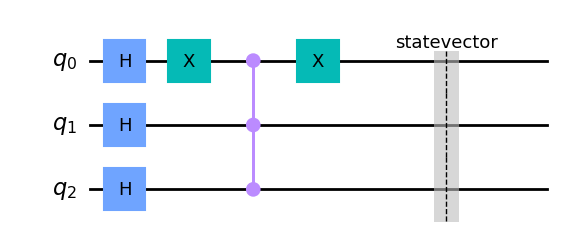

In [35]:
# Queremos invertir el estado |10>
n = 3
s = 6 # 110 en binario

# Creamos el circuito
qc_pinv = QuantumCircuit(n)

# Ponemos los qbits en superposición
for q in range(n):
    qc_pinv.h(q)

# Invertimos los cubits para los que s tenga un bit a 0
temp = s
for b in range(n):
    if(temp&1 == 0):
        qc_pinv.x(b)
    temp >>= 1
        
qc_pinv.ccz(0,1,2)  # El cambio de fase afecta a |s>

# Volvemos a invertir los cubits para los que s tenga un bit a 0
temp = s
for b in range(n):
    if(temp&1 == 0):
        qc_pinv.x(b)
    temp >>= 1
        
qc_pinv.save_statevector()        
qc_pinv.draw('mpl')

In [36]:
job_sim = execute(qc_pinv, sim)         # Hacemos la simulación 
result = job_sim.result()           # Obtenemos los resultados
estado_final = result.get_statevector()
estado_final.draw("latex")

<IPython.core.display.Latex object>

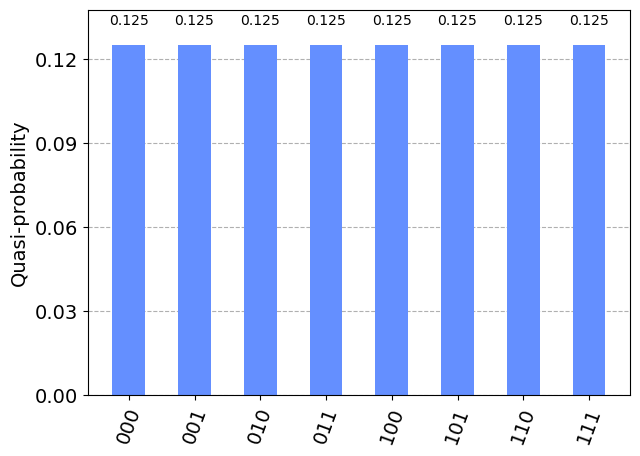

In [37]:
salida = result.get_counts()
plot_histogram(salida)

Si queremos hacerlo para un numero arbitrario de cúbits se puede usar una puerta [MCMT](https://qiskit.org/documentation/stubs/qiskit.circuit.library.MCMT.html)

/home/jorge.vazquez.perez/miniconda3/envs/basic-quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


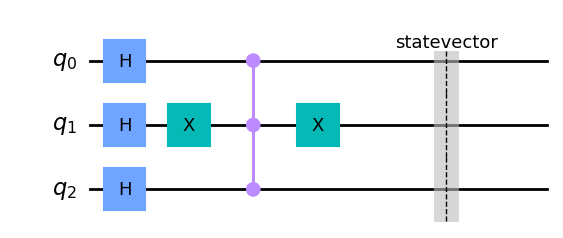

In [38]:
from qiskit.circuit.library import MCMT

def inversor(n,s):
    # Creamos el circuito
    qc = QuantumCircuit(n)

    # Invertimos los cubits para los que s tenga un bit a 0
    temp = s
    for b in range(n):
        if(temp&1 == 0):
            qc.x(b)
        temp >>= 1

    qc = qc.compose(MCMT('z',n-1,1)) # Puerta Z con n-1 control y 1 target

    # Volvemos a invertir los cubits para los que s tenga un bit a 0
    temp = s
    for b in range(n):
        if(temp&1 == 0):
            qc.x(b)
        temp >>= 1
    return qc

n=3
s=5
qc_pinv = QuantumCircuit(n)
# Ponemos los qbits en superposición
for q in range(n):
    qc_pinv.h(q)

# Añadimos el inversor
qc_pinv = qc_pinv.compose(inversor(n,s))
qc_pinv.save_statevector()        
qc_pinv.draw('mpl')

In [39]:
job_sim = execute(qc_pinv, sim)         # Hacemos la simulación 
result = job_sim.result()           # Obtenemos los resultados
estado_final = result.get_statevector()
estado_final.draw("latex")

<IPython.core.display.Latex object>

Podemos ver la matriz unitaria equivalente del inversor

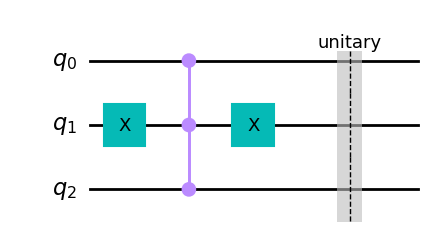

<IPython.core.display.Math object>

In [40]:
qc_inv = inversor(n,s)
qc_inv.save_unitary()
display(qc_inv.draw('mpl'))

# Ejecuta y obtén la unitaria
result = execute(qc_inv, sim_u).result()
unitary = result.get_unitary(qc_inv)
array_to_latex(unitary, pretext="U = ")

Podemos generalizar el inversor para que invierta varios de los estados. Para ello, usamos s como una lista con los estados que queremos invertir.

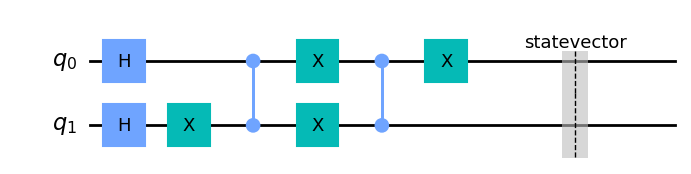

In [54]:
from qiskit.circuit.library import MCMT

# Ahora s es una lista con los estados que queremos invertir
def inversor(n,slist):
    # Creamos el circuito
    qc = QuantumCircuit(n)

    # Invertimos los cubits para los que s tenga un bit a 0
    for s in slist:
        temp = s
        for b in range(n):
            if(temp&1 == 0):
                qc.x(b)
            temp >>= 1

        qc = qc.compose(MCMT('z',n-1,1)) # Puerta Z con n-1 control y 1 target

        # Volvemos a invertir los cubits para los que s tenga un bit a 0
        temp = s
        for b in range(n):
            if(temp&1 == 0):
                qc.x(b)
            temp >>= 1
    return qc

n=2
s=[1,2]
qc_pinv = QuantumCircuit(n)
# Ponemos los qbits en superposición
for q in range(n):
    qc_pinv.h(q)

# Añadimos el inversor
qc_pinv = qc_pinv.compose(inversor(n,s))
qc_pinv.save_statevector()        
qc_pinv.draw('mpl')

In [55]:
job_sim = execute(qc_pinv, sim)         # Hacemos la simulación 
result = job_sim.result()           # Obtenemos los resultados
estado_final = result.get_statevector()
estado_final.draw("latex")

<IPython.core.display.Latex object>

### Oraculo para Grover

En este inversor no tenemos en cuenta la ancilla. Si queremos hacer el circuito que hemos presentado, basta con incluir la ancilla y reemplazar el CZ por un CNOT siendo la ancilla el target.

In [43]:
from qiskit.circuit.library import MCMT

def grover_oraculo(n,s):
    x = QuantumRegister(n, name="|x\\rangle")
    ancilla = QuantumRegister(1, name="|ancilla\\rangle")

    oracle = QuantumCircuit(x, ancilla)
    
    # Invertimos los cubits para los que s tenga un bit a 0
    temp = s
    for b in range(n):
        if(temp&1 == 0):
            oracle.x(b)
        temp >>= 1
    # Aplicamos una CCNOT 
    oracle = oracle.compose(MCMT('x',n,1))
    # Invertimos los cubits para los que s tenga un bit a 0
    temp = s
    for b in range(n):
        if(temp&1 == 0):
            oracle.x(b)
        temp >>= 1
        
    return oracle

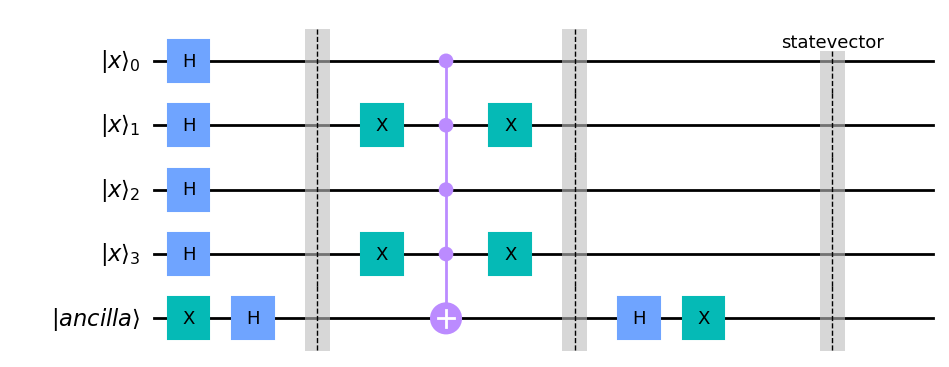

In [44]:
n = 4
s = 5 # 010 en binario

x = QuantumRegister(n, name="|x\\rangle")
ancilla = QuantumRegister(1, name="|ancilla\\rangle")

qc_pinv = QuantumCircuit(x, ancilla)

# Invertimos la ancilla
qc_pinv.x(ancilla)

# Ponemos los cúbits en superposición
qc_pinv.h(range(n+1))

qc_pinv.barrier()

# Añadimos el oraculo
qc_pinv = qc_pinv.compose(grover_oraculo(n,s))

qc_pinv.barrier()

# Ponemos la ancilla a 0 para ver mejor el vector de estado
qc_pinv.h(ancilla)
qc_pinv.x(ancilla)

qc_pinv.save_statevector()        
qc_pinv.draw('mpl')

In [45]:
job_sim = execute(qc_pinv, sim)         # Hacemos la simulación 
result = job_sim.result()           # Obtenemos los resultados
estado_final = result.get_statevector()
estado_final.draw("latex")

<IPython.core.display.Latex object>

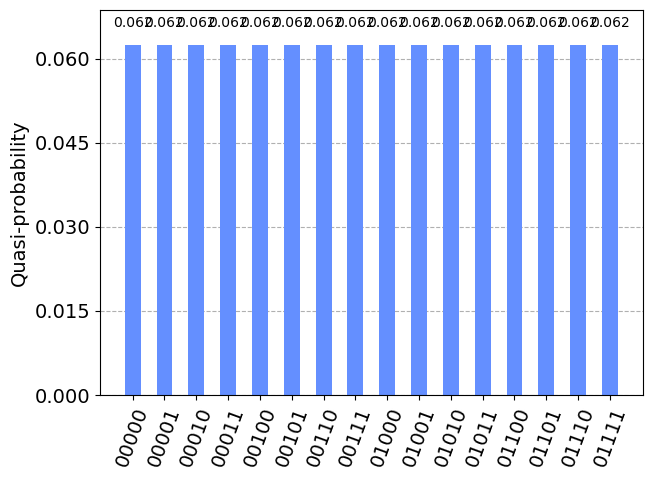

In [46]:
salida = result.get_counts()
plot_histogram(salida)

El problema es que, al medir, obtenemos con igual probabilidad cualquier valor de $|x\rangle$ ya que lo único que diferencia a $|x_i\rangle$ es la fase. Necesitamos convertir diferencias de fase en diferencias de amplitud.

## Amplificación de amplitud

La AA se basa en aumentar la amplitud de los estados que tengan una fase negativa. La idea básica es la *inversión sobre la media*.

Supongamos el vector (decimal) $v=[10,10,10,-10,10]^T$. La media de esos valores es $\overline{v}=6$. 

Invertir sobre la media consiste en repetir esta operación:

$$
v^\prime = \overline{v} + (\overline{v}-v) = 2\overline{v} -v,\quad i = 0,1,2\ldots
$$

cambiando en cada iteración el signo del elemento negativo de $v$.

Aplicando esta operación al vector anterior obtenemos $v^\prime=[2,2,2,22,2]^T$. La media sigue siendo la misma pero el tercer valor, antes negativo, se separa del resto.

Si negamos el tercer elemento tenemos $v=[2,2,2,-22,2]^T$ de media $\overline{v}=-2.8$.

Repitiendo el procedimiento, obtenemos $v^\prime=[-7.6,-7.6,-7.6,16.4,-7.6]^T$. La diferencia entre $v[3]$ y el resto de valores pasa a ser de 24.

A medida que aplicamos la inversión sobre la media esta diferencia se agranda, pero llega un punto en que empieza a disminuir (cuando al invertir el elemento se igualan los signos). Se puede demostrar que para un vector de $N$ elementos, el número de inversiones que obtienen la máxima separación es $\mathcal{O}(\sqrt{N})$.

Podemos expresar este mecanismo usando matrices. Sea, de nuevo, $v=[10,10,10,-10,10]^T$ y la matriz:

$$
A=\frac{1}{5}
\begin{bmatrix}
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1\\
1 & 1 & 1 & 1 & 1
\end{bmatrix}
$$

Está claro que $Av = [6,6,6,6,6]^T = [\overline{v}, \overline{v}, \overline{v}, \overline{v}, \overline{v}]^T$. La operación de inversión la podemos expresar como una operación matricial:

$$v^\prime=2Av-v=(2A-I)v$$

Para un vector de $2^n$ elementos, la matriz $2A-1$ será de $2^n\times 2^n$:
$$
2A-I=\frac{2}{2^n}
  \begin{bmatrix}
    1 & 1 & \dots & 1 \\
    1 & 1 & \dots & 1 \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & 1 & \dots & 1
  \end{bmatrix}-
  \begin{bmatrix}
    1 & 0 & \dots & 0 \\
    0 & 1 & \dots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \dots & 1
  \end{bmatrix} =\frac{1}{2^{n-1}}
  \begin{bmatrix}
    1-2^{n-1} & 1 & \dots & 1 \\
    1 & 1-2^{n-1} & \dots & 1 \\
    \vdots & \vdots & \ddots & \vdots \\
    1 & 1 & \dots & 1-2^{n-1}
  \end{bmatrix}
$$

Se puede demostrar que $U = 2A-I$ es una matriz unitaria, por lo que se puede contruir en un circuito cuántico. 
 

Para el caso de 2 cúbits, la matriz $2A-I$ queda:
$$
2A-I=\frac{1}{2}
  \begin{bmatrix}
    -1 & 1 & 1 & 1 \\
    1 & -1 & 1 & 1 \\
    1 & 1 & -1 & 1 \\
    1 & 1 & 1 & -1
  \end{bmatrix}
$$

Esta matriz se llama operador de difusión o _difusor_ $R_s$. 

Es fácil verificar que si $|s\rangle = |+\rangle^{\otimes n}$ es el estado de superposición completa, entonces $A = |s\rangle\langle s|$, por lo que:

$$
R_s = 2A-I = 2|s\rangle\langle s| -I
$$

#### Implementación de $R_s$

Dado que $|s\rangle = |+\rangle^{\otimes n}= H^{\otimes n}|0\rangle^{\otimes n}$ se tiene :

$$
R_s = 2\left(H^{\otimes n}|0\rangle^{\otimes n}\langle 0|^{\otimes n}H^{\dagger\otimes n}\right)-I = 2\left(H^{\otimes n}|0\rangle^{\otimes n}\langle 0|^{\otimes n}H^{\otimes n}\right)-I
$$

ya que $H^\dagger = H$. 

Además, podemos escribir $I = H^{\otimes n}H^{\otimes n}$. Por lo tanto:

$$
R_s = 2\left(H^{\otimes n}|0\rangle^{\otimes n}\langle 0|^{\otimes n}H^{\otimes n}\right)- H^{\otimes n}H^{\otimes n} = H^{\otimes n}\left(2|0\rangle^{\otimes n}\langle 0|^{\otimes n}-I\right)H^{\otimes n} = H^{\otimes n}R_0H^{\otimes n}
$$

siendo:

$$
R_0 = 2|0\rangle^{\otimes n}\langle 0|^{\otimes n}-I
$$

Es decir, podemos implementar $R_s$ como $R_0$ rodeado de puertas H:

<img src="images/difusor0.svg" alt="Difusor Rs" style="width: 200px;"/>

#### Implementación de $R_0$

Es posible comprobar que $R_0$ aplicado a cualquier estado cambia el signo de $|i\rangle$ para todo $i\ne 0$.

Ejemplo:

$$
R_0|++\rangle = \frac{1}{2}\left(2|00\rangle\langle 00|-I\right)\left(|00\rangle+|01\rangle+|10\rangle+|11\rangle\right) = \\
\frac{1}{2}\left(2|00\rangle\langle 00|00\rangle + 2|00\rangle\langle 00|01\rangle + 2|00\rangle\langle 00|10\rangle + 2|00\rangle\langle 00|11\rangle - |00\rangle-|01\rangle-|10\rangle-|11\rangle\right) = \frac{1}{2}\left(|00\rangle-|01\rangle-|10\rangle-|11\rangle\right)
$$

Para implementar esta operación, podemos empezar usando una puerta Z controlada:

<img src="images/difusor1.svg" alt="Difusor R0" style="width: 100px;"/>

Si se aplica al estado $|+\rangle^{\otimes n}$ cambia el signo del estado $|1\rangle^{\otimes n}$:

$$
\frac{1}{2}\left(|00\rangle+|01\rangle+|10\rangle-|11\rangle\right)
$$

Si añadimos puertas X a todos los cúbits, cambiamos el signo del estado $|0\rangle^{\otimes n}$

<img src="images/difusor2.svg" alt="Difusor R0" style="width: 200px;"/>

$$
\frac{1}{2}\left(-|00\rangle+|01\rangle+|10\rangle+|11\rangle\right)
$$

Para obtener el resultado que buscamos, podemos usar que las puertas ZXZX aplicadas a un cúbit le cambián el signo:

$$
ZXZX|\phi\rangle = -|\phi\rangle
$$

Si se aplican estas puertas al cúbit más significativo, obtendremos el resultado:


<img src="images/difusor3.svg" alt="Difusor R0" style="width: 400px;"/>

$$
\frac{1}{2}\left(|00\rangle-|01\rangle-|10\rangle-|11\rangle\right)
$$

Se pueden simplificar las dos X consecutivas, por lo que la implementación de $R_0$ queda:

<img src="images/difusor4.svg" alt="Difusor R0" style="width: 400px;"/>



### Ejercicio 9

Programa en Qiskit una función que devuelva una puerta $R_s$ para un número arbitrario de cúbits.

Obtén la matriz unitaria asociada y comprueba que coincide con lo esperado. 

/home/jorge.vazquez.perez/miniconda3/envs/basic-quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


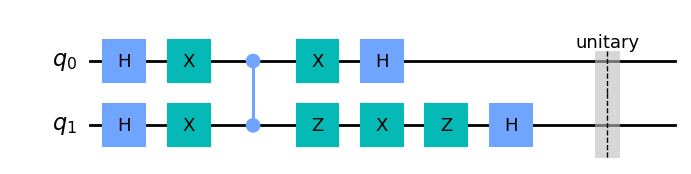

In [47]:
from qiskit.circuit.library import MCMT

def difusor(nqubits):
    qc = QuantumCircuit(nqubits)
    # Transforma |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
        
    # Transforma |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
        
    # Implementa una puerta Z multicontrolada
    # Una forma de hacer una Z multicontrolada con H y Toffoli
    #qc.h(nqubits-1)
    #qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    #qc.h(nqubits-1)
    # Directamente con MCMT
    qc = qc.compose(MCMT('z',nqubits-1, 1))
    
    # Transforma |11..1> -> |00..0>
    for qubit in range(nqubits-1):
        qc.x(qubit)
        
    # Cambia el signo de |00..0>
    qc.z(nqubits-1)
    qc.x(nqubits-1)
    qc.z(nqubits-1)
    
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    return qc

qc_dif = difusor(2)

qc_dif.save_unitary()

qc_dif.draw('mpl')

In [48]:
# Ejecuta y obtén la unitaria
result = execute(qc_dif, sim_u).result()
unitary = result.get_unitary(qc_dif)
array_to_latex(unitary, pretext="2A - I = ")

<IPython.core.display.Math object>

Juntando la inversión de fase con la amplificación de amplitud, el circuito que implementa el algoritmo de Grover queda:

<img src="images/Grover2.svg" alt="Grover completo" style="width: 800px;"/>

## Interpretación geométrica del algoritmo de Grover

Sea $|s\rangle$ el estado inicial del algoritmo de Grover (superposición completa) y sea $w$ el valor para el que $f(w)=1$. Podemos escribir el estado inicial como:

$$
|s\rangle = \frac{1}{\sqrt{2^{n}}}{\sum_{x=0}^{2^n-1}|x\rangle} = \frac{\sum_{x\ne w}|x\rangle + |w\rangle}{\sqrt{2^{n}}} = \sqrt{\frac{2^n-1}{2^n}}\frac{1}{\sqrt{2^n-1}}\sum_{x\ne w}|x\rangle + \frac{1}{\sqrt{2^n}}|w\rangle
$$

Si denotamos:
$$
\begin{aligned}
|r\rangle &= \frac{1}{\sqrt{2^n-1}}\sum_{x\ne x_i}|x\rangle\\
N &= 2^n
\end{aligned}
$$

podemos escribir este estado como:

$$
|s\rangle = \frac{1}{\sqrt{N}}|w\rangle + \sqrt{\frac{N-1}{N}}|r\rangle
$$

Y como 

$$
\left(\frac{1}{\sqrt{N}}\right)^2 + \left(\sqrt{\frac{N-1}{N}}\right)^2 = 1 
$$

existe $\theta$ tal que podemos escribir el estado como:

$$
|s\rangle =\sin\theta|w\rangle + \cos\theta|r\rangle
$$

Podemos representar este estado así:

<img src="images/GeoGrover1.png" alt="Geo Grover 1" style="width: 200px;"/>

Si a este estado le aplicamos la inversión de fase, $U_f$, se le cambia el signo a $|w\rangle$:

$$
U_f|s\rangle = -\sin\theta|w\rangle + \cos\theta|r\rangle
$$

que equivale a una reflexión con respecto al eje $|r\rangle$:

<img src="images/GeoGrover2.png" alt="Geo Grover 2" style="width: 200px;"/>

Ahora aplicamos la amplificación de amplitud. El difusor $R_s = 2|s\rangle\langle s| -I$ mantiene el estado $|s\rangle$ pero invierte cualquier estado ortogonal a $|s\rangle$:

$$
\begin{aligned}
R_s|s\rangle &= 2|s\rangle\langle s|s\rangle - |s\rangle = 2|s\rangle - |s\rangle = |s\rangle\\
R_s|s^\perp\rangle &= 2|s\rangle\langle s|s^\perp\rangle - |s^\perp\rangle = -|s^\perp\rangle\\
\end{aligned}
$$

ya que $\langle s|s\rangle=1$ y $\langle s|s^\perp\rangle=0$. Es decir, $R_s$ produce una reflexión sobre $|s\rangle$.

Si aplicamos $R_s$ al estado $U_f|s\rangle$ tendremos el estado reflejado sobre $|s\rangle$:

<img src="images/GeoGrover3.png" alt="Geo Grover 2" style="width: 200px;"/>

Si aplicamos de nuevo las dos reflexiones $U_f$ y $R_s$ tendremos:

<img src="images/GeoGrover4.png" alt="Geo Grover 4" style="width: 200px;"/>

Si continuamos aplicando las reflexiones, el estado se irá acercando a $|w\rangle$ que es la solución buscada.

**¿Cuándo se alcanza $|w\rangle$?**

Cada vez que aplicamos las reflexiones, el estado avanza un ángulo $2\theta$ con respecto a $|s\rangle$. Sea $t$ el número de reflexiones para llegar a $|w\rangle$:

$$
\begin{aligned}
\theta + 2\theta\cdot t = \frac{\pi}{2} \Rightarrow t = \frac{\pi}{4\theta} - \frac{1}{2}
\end{aligned}
$$

Como $\sin\theta = \frac{1}{\sqrt{N}}$, si $N$ es grande:

$$
\theta = \sin^{-1}\left(\frac{1}{\sqrt{N}}\right) \approx \frac{1}{\sqrt{N}}
$$

Por lo que:

$$
t \approx \frac{\pi}{4}\sqrt{N} - \frac{1}{2} \approx \frac{\pi}{4}\sqrt{N}
$$

Por lo que el número de repeticiones del algoritmo es $\mathcal{O}(\sqrt{2^n})$

**Problema**: Si hacemos más repeticiones de las necesarias nos alejamos de la solución

<img src="images/GroverItera.png" alt="Iteraciones Grover" style="width: 800px;"/>
Fuente: Combarro, E.F., González-Castillo, S., "A practical Guide to QML and Quantum Optimization", Packt, 2023

En la figura se muestra el caso de $n = 4$. El número optimo de iteraciones sería $\left\lfloor\frac{\pi}{4}\sqrt{16}\right\rfloor = 3.$ Si hacemos más de 3 iteraciones, la probabilidad de éxito cae.

**Caso con más de un elemento marcado**

Sí tenemos $k$ elementos marcados, con $k \ll N$, el número de iteraciones adecuado es:

$$
t = \left\lfloor\frac{\pi}{4}\sqrt{N/k}\right\rfloor
$$

Si $k$ es desconocido, el trabajo de [Boyer et al.](https://onlinelibrary.wiley.com/doi/abs/10.1002/(SICI)1521-3978(199806)46:4/5%3C493::AID-PROP493%3E3.0.CO;2-P) demuestra que eligiendo un valor de $t$ arbitrario dentro de un rango, la complejidad se mantiene $\mathcal{O}\left(\sqrt{2^n}\right)$. 

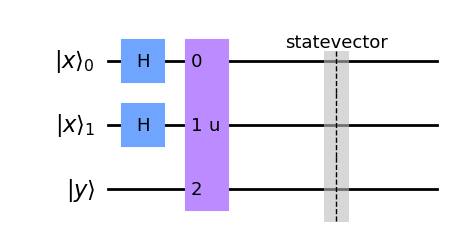

<IPython.core.display.Math object>

In [49]:
from qiskit.quantum_info.operators import Operator

# Matriz f3
x = QuantumRegister(2, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)

qc.h(x[0])
qc.h(x[1])
u = Operator([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1],
])
qc.unitary(u, [0, 1, 2], label='u')
qc.save_statevector()
display(qc.draw('mpl'))

# Ejecutamos una simulación 
job_sim = execute(qc, sim, shots=1)

# Obtenemos los resultados
result = job_sim.result()

# Obtenemos el vector de estado del circuito
estado = result.get_statevector()
# Muestra estado
array_to_latex(estado, pretext="|\psi\\rangle = ")

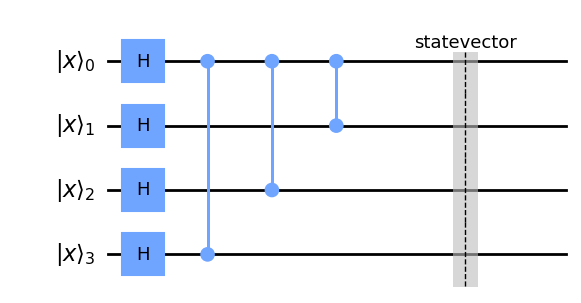

<IPython.core.display.Math object>

In [53]:
from qiskit.circuit.library import MCMT

# Matriz f3
x = QuantumRegister(4, name="|x\\rangle")
qc = QuantumCircuit(x)

qc.h(range(4))
qc.cz(0, 3)
qc.cz(0, 2)
qc.cz(0, 1)

qc.save_statevector()
display(qc.draw('mpl'))

# Ejecutamos una simulación 
job_sim = execute(qc, sim, shots=1)

# Obtenemos los resultados
result = job_sim.result()

# Obtenemos el vector de estado del circuito
estado = result.get_statevector()
# Muestra estado
array_to_latex(estado, pretext="|\psi\\rangle = ")

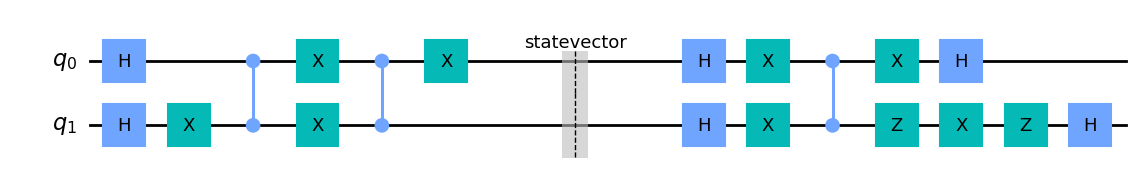

In [59]:
from qiskit.circuit.library import MCMT

# Ahora s es una lista con los estados que queremos invertir
def inversor(n,slist):
    # Creamos el circuito
    qc = QuantumCircuit(n)

    # Invertimos los cubits para los que s tenga un bit a 0
    for s in slist:
        temp = s
        for b in range(n):
            if(temp&1 == 0):
                qc.x(b)
            temp >>= 1

        qc = qc.compose(MCMT('z',n-1,1)) # Puerta Z con n-1 control y 1 target

        # Volvemos a invertir los cubits para los que s tenga un bit a 0
        temp = s
        for b in range(n):
            if(temp&1 == 0):
                qc.x(b)
            temp >>= 1
    return qc

from qiskit.circuit.library import MCMT

def difusor(nqubits):
    qc = QuantumCircuit(nqubits)
    # Transforma |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
        
    # Transforma |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
        
    # Implementa una puerta Z multicontrolada
    # Una forma de hacer una Z multicontrolada con H y Toffoli
    #qc.h(nqubits-1)
    #qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    #qc.h(nqubits-1)
    # Directamente con MCMT
    qc = qc.compose(MCMT('z',nqubits-1, 1))
    
    # Transforma |11..1> -> |00..0>
    for qubit in range(nqubits-1):
        qc.x(qubit)
        
    # Cambia el signo de |00..0>
    qc.z(nqubits-1)
    qc.x(nqubits-1)
    qc.z(nqubits-1)
    
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    return qc

n=2
s=[1,2]
qc = QuantumCircuit(n)
# Ponemos los qbits en superposición
for q in range(n):
    qc.h(q)

# Añadimos el inversor
qc = qc.compose(inversor(n,s))
qc.save_statevector() 
qc = qc.compose(difusor(n))
       
qc.draw('mpl')

In [60]:
job_sim = execute(qc_pinv, sim)         # Hacemos la simulación 
result = job_sim.result()           # Obtenemos los resultados
estado_final = result.get_statevector()
estado_final.draw("latex")

<IPython.core.display.Latex object>